## 由于原来的坡度信息，存在一些不“标准”的数据，这里需要进行标准化

### 找到一个数据集的中心倾向和分布的度量，从而让你的坡度数据更加规范化和标准化。以下是你可以按照的步骤：

1. **数据可视化**：
    - 首先，你需要对你的坡度数据进行可视化，例如绘制直方图或核密度估计图，以了解数据的分布形态。这可以帮助你直观地看到数据是否接近正态分布。

2. **计算均值和标准差**：
    - 使用你的坡度数据计算均值和标准差。这两个统计量可以帮助你了解数据的中心位置和分布的范围。

3. **标准化数据**：
    - 标准化是一个使数据具有零均值和单位方差的过程。公式如下：
      \[ Z = \frac{X - \mu}{\sigma} \]
      其中 \( Z \) 是标准化后的值，\( X \) 是原始值，\( \mu \) 是均值，\( \sigma \) 是标准差。

4. **去除异常值**：
    - 在你绘制的直方图或其他可视化图中，你可能会观察到一些远离中心位置的数据点，这些可能是异常值。一个常见的做法是去除那些落在均值之外3个标准差范围的数据点。这样，你可以保留大约99.7%的数据（如果它们是正态分布的话）。

5. **再次可视化和检验**：
    - 对处理后的数据再次进行可视化，并进行正态性检验，例如Shapiro-Wilk检验或Kolmogorov-Smirnov检验，以确认数据的分布是否更接近正态分布。

6. **应用到PSO算法**：
    - 使用处理和标准化后的数据进行PSO拟合。这样，你的模型会更加稳定和健壮，因为它是基于更标准化的数据进行训练的。

记住，虽然正态分布是许多统计方法的一个常见假设，但并不是所有的数据都需要或应该被强制转换为正态分布。在某些情况下，转换数据的真实结构可能会导致信息丢失或模型效果下降。因此，始终建议在进行此类转换之前首先理解你的数据和建模需求。

### 读取一个地块内的 Slope 数据

In [8]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely import Point, Polygon, LineString
from CPP_Planner import CPP_Planner_Kit

In [9]:
dem_src = rasterio.open('GIS_data/路径规划优化用数据/2m_pClouds_regen_dem_cm.tif')
slope_src = rasterio.open('GIS_data/路径规划优化用数据/Slope_clip_pcGen_2m_cm1.tif')
all_land = gpd.read_file('GIS_data/路径规划优化用数据/seperate_land_0.shp')

dem_array = dem_src.read(1)
slope_array = slope_src.read(1)

<AxesSubplot: >

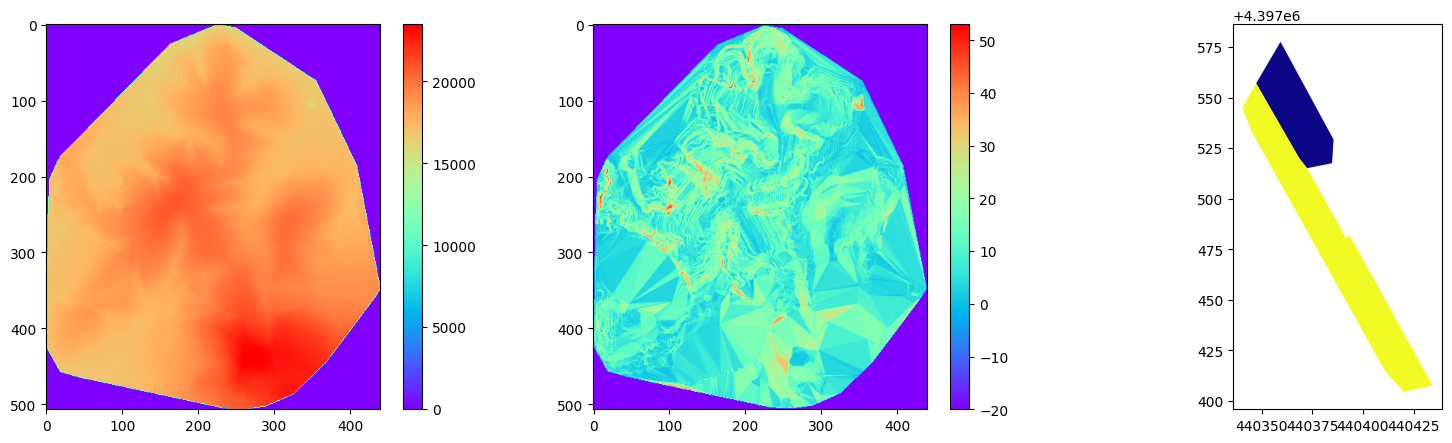

In [10]:
NODATA = -20
dem_array[dem_array == dem_array.min()] = NODATA
slope_array[slope_array == slope_array.min()] = NODATA

# show
fig, axes = plt.subplots(ncols=3, nrows=1, dpi=100, figsize=(20, 5))
im = axes[0].imshow(dem_array, cmap='rainbow')
plt.colorbar(im, ax = axes[0])
im = axes[1].imshow(slope_array, cmap='rainbow')
plt.colorbar(im, ax = axes[1])
all_land.plot(ax = axes[2], cmap='plasma')

In [11]:
# 读取两个地块的 Slope 信息
land_rasters = []
for i in [0, 1]:
    temp_land = CPP_Planner_Kit.get_single_shp(all_land, i)
    temp_land_geom = temp_land.geometry.values.tolist()
    temp_land_raster, temp_raster_tran = mask(slope_src, temp_land_geom, crop=True)
    temp_land_raster[temp_land_raster == temp_land_raster.min()] = NODATA
    land_rasters.append(temp_land_raster[0, :, :])

print("Info: ", [land.shape for land in land_rasters])

Info:  [(32, 20), (77, 48)]


277
653
Dash dot: Median, Dash: Mean


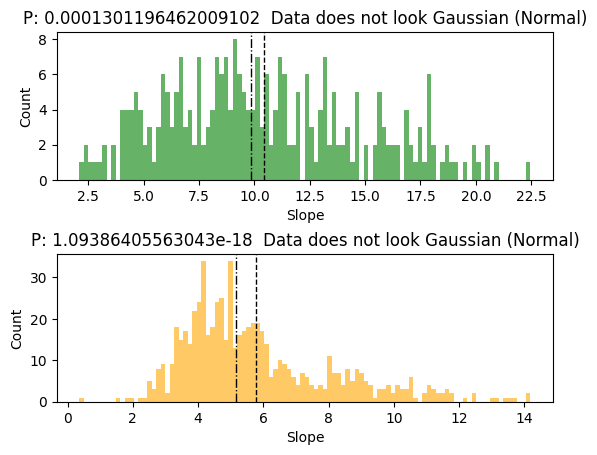

In [12]:
from scipy.stats import shapiro
# 查看两个地块的数据情况
plt.subplots_adjust(hspace=0.5)
plt.subplot(211)
temp_raster = land_rasters[0]
temp_raster = temp_raster[temp_raster != NODATA]
stat, p = shapiro(temp_raster[temp_raster != NODATA])
title = 'P: ' + str(p) + '  '
if p > 0.05:
    title += 'Data looks Gaussian (Normal)'
else:
    title += 'Data does not look Gaussian (Normal)'
print(len(temp_raster))
plt.hist(temp_raster, bins=100, density=False, alpha=0.6, color='g')
temp_median = np.median(temp_raster)
temp_mean = np.mean(temp_raster)
# line
plt.axvline(temp_median, color='k', linestyle='-.', linewidth=1)
plt.axvline(temp_mean, color='k', linestyle='dashed', linewidth=1)
plt.title(title)
plt.xlabel('Slope')
plt.ylabel('Count')

plt.subplot(212)
temp_raster = land_rasters[1]
temp_raster = temp_raster[temp_raster != NODATA]
print(len(temp_raster))
temp_raster = temp_raster[temp_raster != NODATA]
stat, p = shapiro(temp_raster[temp_raster != NODATA])
title = 'P: ' + str(p) + '  '
if p > 0.05:
    title += 'Data looks Gaussian (Normal)'
else:
    title += 'Data does not look Gaussian (Normal)'
plt.hist(temp_raster, bins=100, density=False, alpha=0.6, color='orange')
temp_median = np.median(temp_raster)
temp_mean = np.mean(temp_raster)
# line
plt.axvline(temp_median, color='k', linestyle='-.', linewidth=1)
plt.axvline(temp_mean, color='k', linestyle='dashed', linewidth=1)
plt.title(title)
plt.xlabel('Slope')
plt.ylabel('Count')
print("Dash dot: Median, Dash: Mean")

In [15]:
# 使用 Shapiro-Wilk 检验
from scipy.stats import shapiro
stat, p = shapiro(temp_raster[temp_raster != NODATA])
if p > 0.05:
    print('Data looks Gaussian (Normal)')
else:
    print('Data does not look Gaussian (Normal)')

Data does not look Gaussian (Normal)


0.9288790822029114
0.0


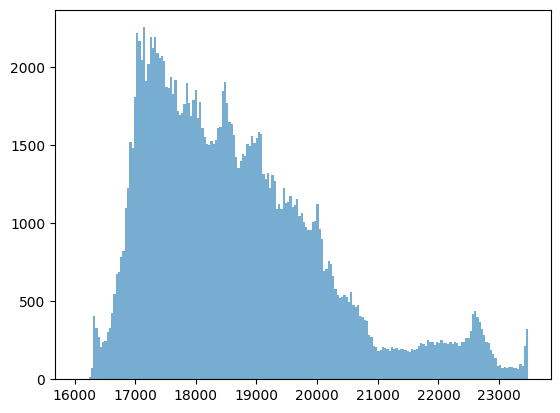

In [22]:
plt.hist(dem_array[dem_array != NODATA], bins=200, density=False, alpha=0.6)
stat, p = shapiro(dem_array[dem_array != NODATA])
print(stat)
print(p)

### 使用 QQ 图来判断数据是否接近正态分布

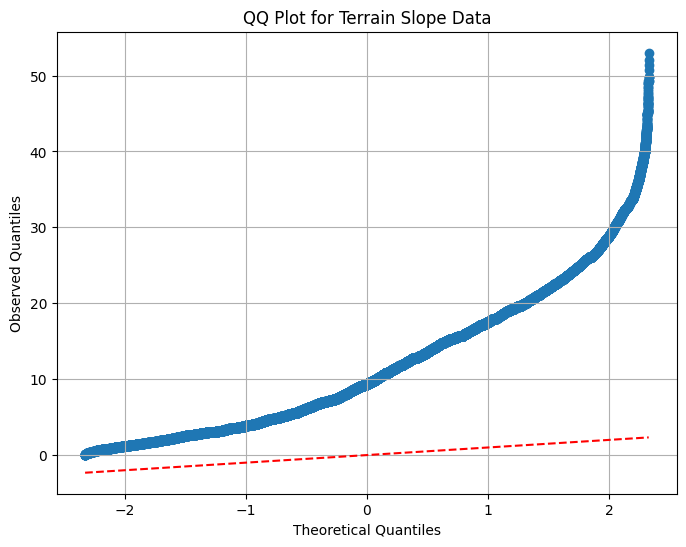

In [21]:
from scipy import stats
slope_array_flatten = slope_array[slope_array != NODATA].flatten()
# calc 
theroetical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(slope_array_flatten)))
# draw QQ
plt.figure(figsize=(8, 6))
plt.scatter(theroetical_quantiles, np.sort(slope_array_flatten))
plt.plot(theroetical_quantiles, theroetical_quantiles, color='red', linestyle='--')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Observed Quantiles')
plt.title('QQ Plot for Terrain Slope Data')
plt.grid(True)